In [1]:
import numpy as np
import pandas as pd
import meanreversion as mr
import matplotlib.pyplot as plt

import meanreversion as mr

In [46]:
# Load asset data
df = mr.load_asset("data/DJ_M15_202009240845_202411131015.csv")
df = df.set_index(pd.DatetimeIndex(df['AbsTime'].values))
df.drop(['AbsTime'], inplace = True, axis = 1)

# Compute moving averages, returns, and ratios
window = 100
df['MA'] = df['Close'].rolling(window=100).mean()
df['Simple_Returns'] = df.pct_change(1)['Close']
df['Log_Returns'] = np.log(1+df['Simple_Returns'])
df['Ratios'] = mr.rectifiy_price(df, "Close", window=window)

# Compute rolling percentiles of the ratios
percentiles = [15, 50, 85]
for p in percentiles:
	df[f'perc_{p}'] =df["Ratios"].rolling(window=len(df)//20).quantile(p/100)

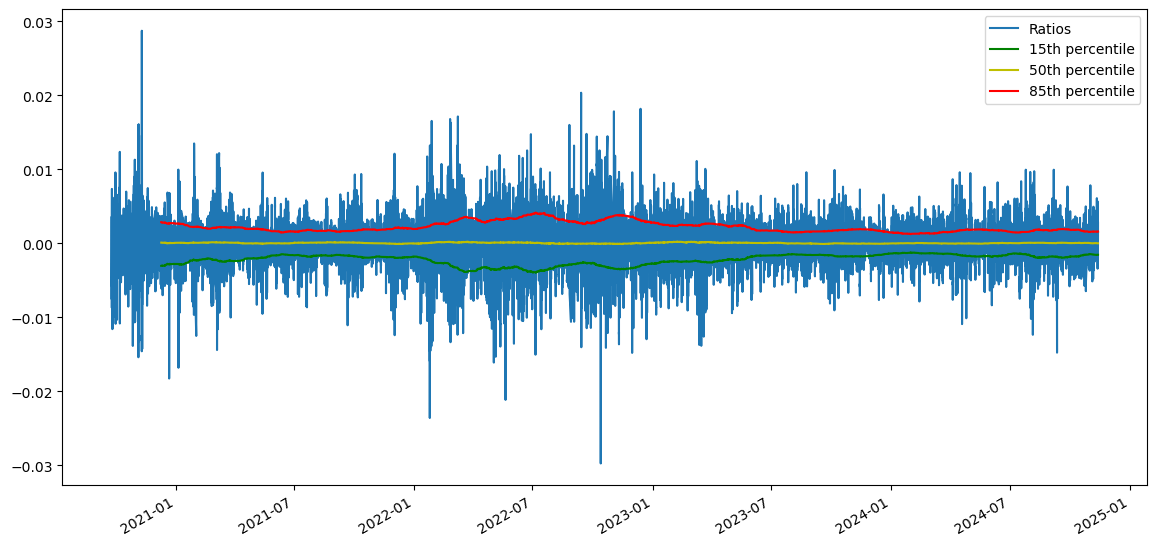

In [47]:
plt.figure(figsize=(14,7))
df['Ratios'].dropna().plot(legend = True)
plt.plot(df['perc_15'], c='g', label = '15th percentile')
plt.plot(df['perc_50'], c='y', label = '50th percentile')
plt.plot(df['perc_85'], c='r', label = '85th percentile')
plt.legend()
plt.show()

In [51]:
# Test with constant MRI indexes
# TODO: replace with real MRI rolling indexes
df['MRI'] = 1.0
df.loc[(df.index >= '2021-01-01') & (df.index < '2021-01-01'), 'MRI'] = 2 
df.loc[(df.index >= '2022-01-01') & (df.index < '2023-01-01'), 'MRI'] = 0.5 
df.loc[(df.index >= '2023-01-01') & (df.index < '2025-01-01'), 'MRI'] = 1

# Buy and sell signals: buy (+1) when the ratio is below the 15th percentile, sell (-1) when it is above the 85th percentile
df['Positions'] = np.where(df.Ratios > df['perc_85'], -1, 0)
df['Positions'] = np.where(df.Ratios < df['perc_15'], 1, df['Positions'])
df['Positions'] = df['Positions'].ffill()

# Compute current and previous buy and sell prices
df['Buy'] = np.where(df['Positions'] == 1 , df['Close'], np.nan)
df['Sell'] = np.where(df['Positions'] == -1 , df['Close'], np.nan)
df['Previous_Buy'] = df['Buy'].shift(1)
df['Previous_Sell'] = df['Sell'].shift(1) 

df['Investment'] = np.where(df['Buy'].notna(), df['Buy'] * df['MRI'], 0)
df['Revenue'] = np.where(df['Sell'].notna(), df['Sell'] * df['MRI'], 0)
df['Profit'] = df['Revenue'] - df['Investment']
df['Cum_Profit'] = df['Profit'].cumsum()

df['Strategy_Returns'] = df.Positions.shift(1)*df.Log_Returns

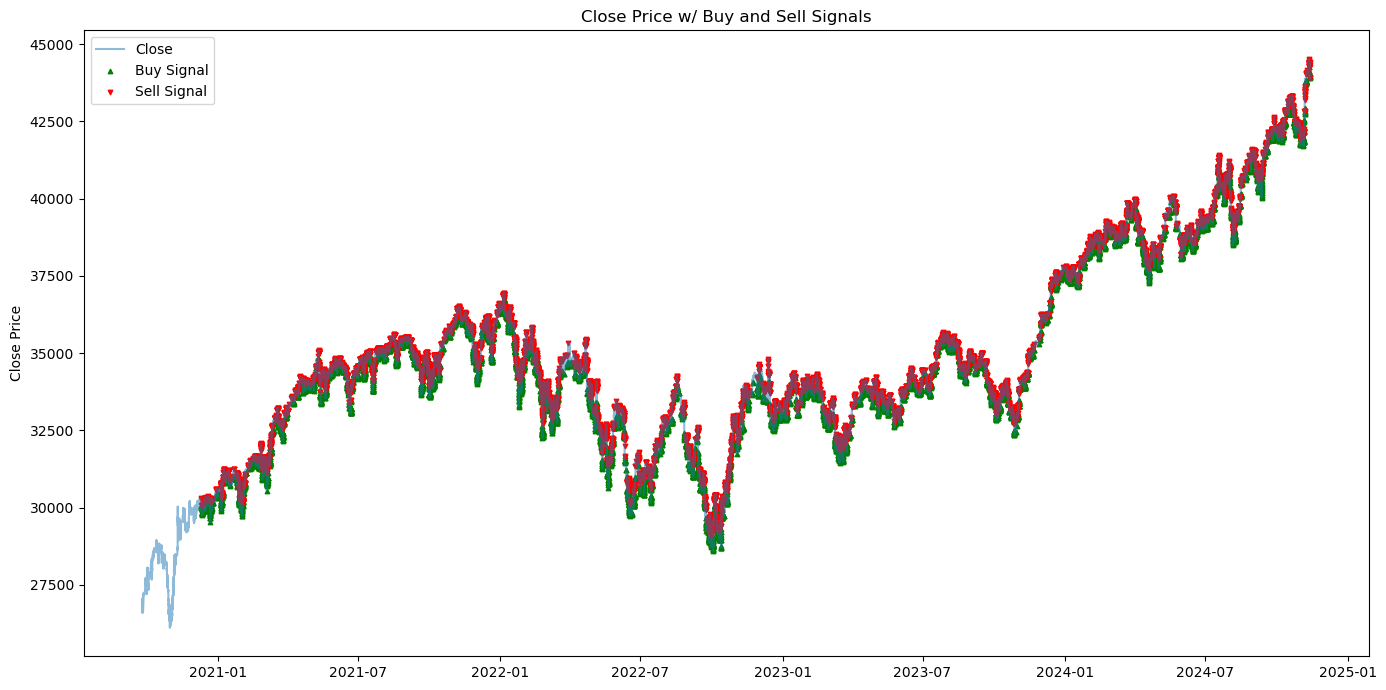

In [52]:
fig, axes = plt.subplots(1, 1, figsize=(14, 7))
axes.set_title('Close Price w/ Buy and Sell Signals')
axes.plot(df['Close'], alpha=0.5, label='Close')
axes.scatter(df.index, df['Buy'], c='g', label='Buy Signal', marker='^', s=10)
axes.scatter(df.index, df['Sell'], c='r', label='Sell Signal', marker='v', s=10)
axes.set_ylabel('Close Price')
axes.legend()
plt.tight_layout()
plt.show()

Buy & Hold Strategy Returns: 0.639418738734691
Mean reversion Strategy Returns: 1185.0267820513052


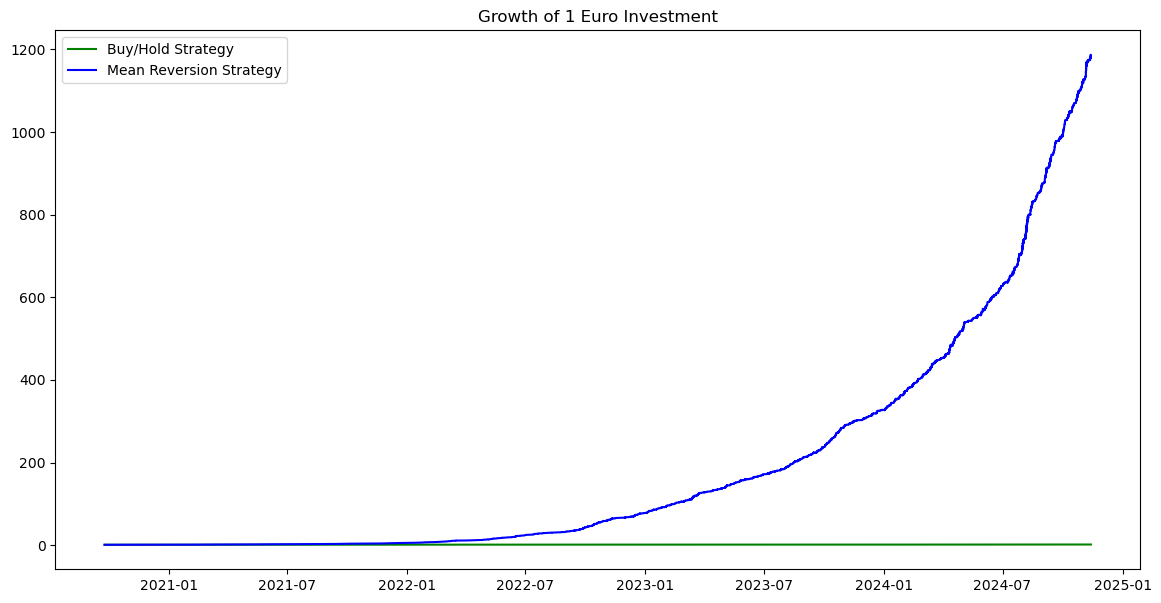

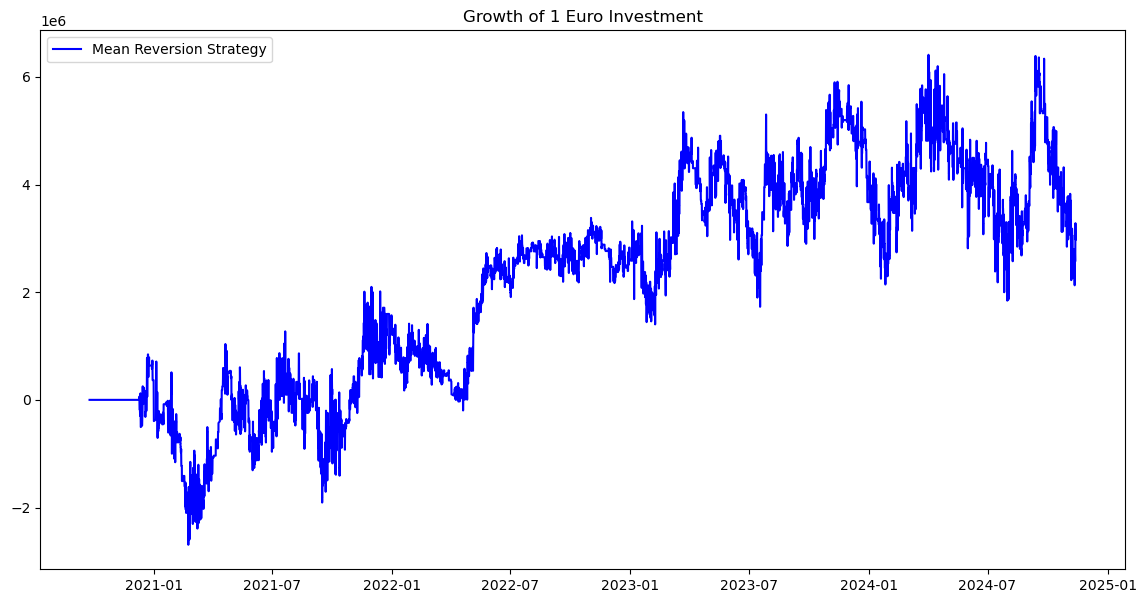

In [84]:
print('Buy & Hold Strategy Returns:', np.exp(df['Log_Returns'].dropna()).cumprod().iloc[-1] - 1.0) 
print('Mean reversion Strategy Returns:', np.exp(df['Strategy_Returns'].dropna()).cumprod().iloc[-1] - 1.0)

plt.figure(figsize=(14,7))
plt.title('Growth of 1 Euro Investment')
plt.plot(np.exp(df['Log_Returns'].dropna()).cumprod(), c = 'g', label = 'Buy/Hold Strategy')
plt.plot(np.exp(df['Strategy_Returns'].dropna()).cumprod(), c = 'b', label = 'Mean Reversion Strategy')
plt.legend()
plt.show()

plt.figure(figsize=(14,7))
plt.title('Growth of 1 Euro Investment')
plt.plot(df['Cum_Profit'].dropna(), c = 'b', label = 'Mean Reversion Strategy')
plt.legend()
plt.show()